## 实验：欠拟合与过拟合

### 实验概要

#### 过拟合和欠拟合

模型训练中经常出现两类典型问题：

- 一类是模型无法得到较低的训练误差，我们将这一现象称作 **欠拟合（underfitting）**
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为 **过拟合（overfitting）**

在实践中，我们要尽可能同时应对欠拟合和过拟合。虽然有很多因素可能导致这两种拟合问题，在这里我们重点讨论两个因素：模型复杂度和训练数据集大小。

#### 模型复杂度

为了解释模型复杂度，我们以多项式函数拟合为例。给定一个由标量数据特征 $x$ 和对应的标量标签 $y$ 组成的训练数据集，多项式函数拟合的目标是找一个$K$阶多项式函数

$$\hat{y} = b + \sum_{k=1}^K x^k w_k$$

来拟合 $y$。

在上式中，$w_k$ 是模型的权重参数（weight），$b$ 是偏置参数（bias）。与线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。因为高阶多项式函数模型参数更多，模型函数的选择空间更大，所以高阶多项式函数比低阶多项式函数的复杂度更高。因此，高阶多项式函数比低阶多项式函数更容易在相同的训练数据集上得到更低的训练误差。给定训练数据集，模型复杂度和误差之间的关系通常如图所示。给定训练数据集，如果模型的复杂度过低，很容易出现欠拟合；如果模型复杂度过高，很容易出现过拟合。应对欠拟合和过拟合的一个办法是针对数据集选择合适复杂度的模型。

<img src="./img/overfit_19.jpg" width="50%">

#### 训练数据集大小

影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，如层数较多的深度学习模型。

为了理解模型复杂度和训练数据集大小对欠拟合和过拟合的影响，下面我们以多项式函数拟合为例来实验。

### 实验目标

在本实验中，我们将生成一个人工数据集，通过 TensorFlow 生成神经网络模型，分别观察：正常、欠拟合与过拟合的训练曲线。从而使你对训练曲线的状态建立直观的感知，通过观察训练曲线，更准确的判断模型是否存在过拟合状态。

### 1. 导入库

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 生成数据集

在本实验中，我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征$x$，我们使用如下的三阶多项式函数来生成该样本的标签：

$$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon,$$

其中噪声项 $\epsilon$ 服从均值为 0、标准差为 0.1 的正态分布。训练数据集和测试数据集的样本数都设为 100。

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = tf.random.normal(shape=(n_train + n_test, 1))
poly_features = tf.concat([features, tf.pow(features, 2), 
                           tf.pow(features, 3)], axis=1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + 
          true_w[2] * poly_features[:, 2] + true_b)
labels += tf.random.normal(labels.shape, stddev=0.1)

看一看生成的数据集的前两个样本：

In [3]:
features[:2], poly_features[:2], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.7774429 ],
        [-0.41630965]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-1.7774429 ,  3.1593034 , -5.6154814 ],
        [-0.41630965,  0.17331372, -0.07215218]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-39.31537  ,   3.5542302], dtype=float32)>)

设置训练曲线显示图形的参数：

In [4]:
from IPython import display
def use_svg_display():
    """以 svg 格式在 jupyter notebook 中显示图形"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置 Matplotlib 图形尺寸"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

### 3. 定义、训练和测试模型

我们先定义作图函数 `semilogy`，其中 `y` 轴使用了对数尺度。

In [5]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

和线性回归一样，多项式函数拟合也使用平方损失函数。

因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在 `fit_and_plot` 函数中。

In [6]:
num_epochs, loss = 100, tf.losses.MeanSquaredError()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1))
    batch_size = min(10, train_labels.shape[0])
    train_iter = tf.data.Dataset.from_tensor_slices(
        (train_features, train_labels)).batch(batch_size)
    test_iter = tf.data.Dataset.from_tensor_slices(
        (test_features, test_labels)).batch(batch_size)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                l = loss(y, net(X))

            grads = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))

        train_ls.append(loss(train_labels, net(train_features)).numpy().mean())
        test_ls.append(loss(test_labels, net(test_features)).numpy().mean())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.get_weights()[0],
          '\nbias:', net.get_weights()[1])

### 4. 三阶多项式函数拟合（正常）

我们先使用与数据生成函数同阶的三阶多项式函数拟合。

实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：$w_1 = 1.2, w_2=-3.4, w_3=5.6, b = 5$。

final epoch: train loss 0.00947398 test loss 0.011410384


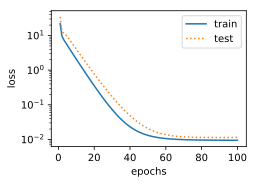

weight: [[ 1.1958038]
 [-3.392395 ]
 [ 5.5950413]] 
bias: [4.9951715]


In [7]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### 5. 线性函数拟合（欠拟合）

我们再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型（如三阶多项式函数）生成的数据集上容易欠拟合。

final epoch: train loss 76.13087 test loss 196.67671


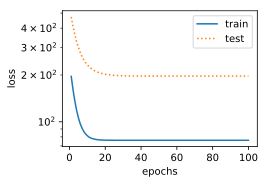

weight: [[12.646394]] 
bias: [2.226844]


In [8]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

### 6. 训练样本不足（过拟合）

事实上，即便使用与数据生成模型同阶的三阶多项式函数模型，如果训练样本不足，该模型依然容易过拟合。让我们只使用两个样本来训练模型。显然，训练样本过少了，甚至少于模型参数的数量。这使模型显得过于复杂，以至于容易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象。

final epoch: train loss 1.9505903 test loss 11.535108


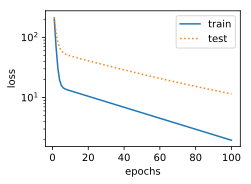

weight: [[-0.31323293]
 [-3.6265852 ]
 [ 5.4798284 ]] 
bias: [2.4761918]


In [9]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

### 实验小结

在本实验中，你在一个多项式函数生成的人工数据集中，分别采用三阶多项式函数拟合、线性函数拟合、以及降低训练样本的方式，展示了当模式处于正常、欠拟合与过拟合状态下的训练曲线形态。